In [1]:
import numpy as np
import pandas as pd
import pyddm
import pyddm.plot
import matplotlib.pyplot as plt
from IPython.display import clear_output
from joblib import Parallel, delayed

# set notebook defaults
%matplotlib inline

**explore drift diffusion model**

In [2]:
# drift diffusion model w/ free parameters
ddm_free = pyddm.gddm(
    drift="drift",  # v: drift rate, ie the amount of evidence that accumulates in 1 sec without noise
    bound="B",  # a/2: the height of the boundary on each side
    starting_position="x0",  # z: initial position of the diffusion process (-1 to +1)
    nondecision=0.2,  # t: nondecision time in sec
    noise=1.0,  # sqrt{dt}: the standard deviation of noise
    parameters=dict(drift=(-2, +2), B=(0.3, 2), x0=(-0.8, 0.8)),  # free parameters
)

# plot ddm, adjust free parameters
pyddm.plot.model_gui_jupyter(ddm_free)

Output()

**parameter recovery experiment**

In [3]:
# drift diffusion model w/ fixed parameters
params = [0.5, 0.6, 0.3]
ddm_fixed = pyddm.gddm(
    drift=params[0], bound=params[1], starting_position=params[2], nondecision=0.2, noise=1.0
)

# ddm -> pdf
solution_fixed = ddm_fixed.solve()

# sample from pdf
sample_fixed = solution_fixed.sample(10_000)

# fit ddm w/ free parameters
ddm_free.fit(sample_fixed, method="analytical", fitting_method="simplex", verbose=False)

Info: Params [0.54898818 0.60422946 0.29638323] gave 2427.9609881781


In [4]:
# !! 15 sec runtime !! #


@delayed
def fit_ddm(ddm, solution, n_samples):
    """sample from fixed ddm, then fit free ddm to sample"""
    sample = solution.sample(n_samples)
    ddm.fit(sample, method="analytical", fitting_method="simplex", verbose=False)
    return ddm.get_model_parameters()


n_repeats, n_samples, n_jobs = 1000, 10_000, -2
with Parallel(n_jobs=n_jobs) as parallel:
    params_ = np.asarray(
        parallel(fit_ddm(ddm_free, solution_fixed, n_samples) for _ in range(n_repeats))
    )
clear_output()

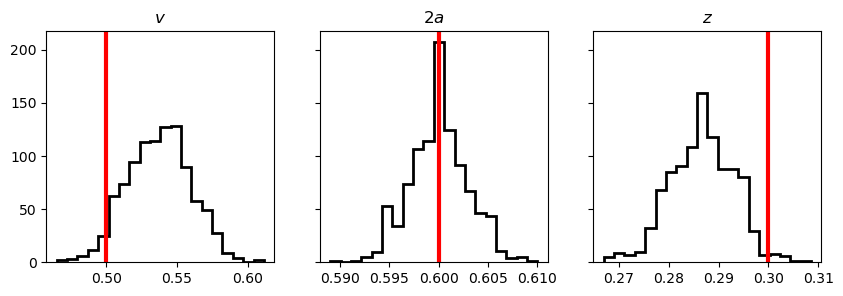

In [5]:
# plot n_samples = 10,000
fig, axs = plt.subplots(ncols=3, figsize=(10, 3), sharey=True)
hist_kwargs = dict(color="k", bins=20, histtype="step", lw=2)
vline_kwargs = dict(color="r", lw=3)
axs[0].set_title(r"$v$")
axs[0].hist(params_[:, 0], **hist_kwargs)
axs[0].axvline(params[0], **vline_kwargs)
axs[1].set_title(r"$2a$")
axs[1].hist(params_[:, 1], **hist_kwargs)
axs[1].axvline(params[1], **vline_kwargs)
axs[2].set_title(r"$z$")
axs[2].hist(params_[:, 2], **hist_kwargs)
axs[2].axvline(params[2], **vline_kwargs)

In [ ]:
# !! 50 sec runtime !! #


def bias_var_mse(params, params_):
    """params (true values), params_ (matrix of estimates)"""
    params_mean_ = params_.mean(axis=0)
    bias_ = np.mean(params_ - params, axis=0)
    var_ = np.mean((params_ - params_mean_) ** 2, axis=0)
    mse_ = np.mean((params_ - params) ** 2, axis=0)
    return bias_, var_, mse_


n_repeats = 1000
n_samples = np.logspace(start=1, stop=4, num=5, dtype=int)  # 10 to 10k

df = {"n": [], "param": [], "bias": [], "var": [], "mse": []}

for n in n_samples:
    with Parallel(n_jobs=n_jobs) as parallel:
        params_ = np.array(parallel(fit_ddm(ddm_free, solution_fixed, n) for _ in range(n_repeats)))
    bias_, var_, mse_ = bias_var_mse(params, params_)
    df["n"].extend([n] * 3)
    df["param"].extend(["v", "a", "z"])
    df["bias"].extend(bias_)
    df["var"].extend(var_)
    df["mse"].extend(mse_)
df = pd.DataFrame(df)
clear_output()